# Lab #1, Deep learning basics, MADE 2023
Student: **Kirill Lyahnovich**

In [1]:
import os
import pickle as pkl
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchmetrics import CharErrorRate as CER
from torchvision import transforms

# Data preprocessing

Изображения сразу переведем в grayscale, потому что они и так черно-белые

Так как датасет небольшой и его еще приходится делить, воспользуемся легкими аугментациями для инъекции шума во входные данные

In [2]:
class ImageDataset(Dataset):
    def __init__(self, images_list, augment=False, extension=".png"):
        self._extension = extension
        self.img_list = images_list

        preprocessing = [transforms.ToTensor()]
        if augment:
            augmentations = [
                transforms.RandomPosterize(bits=5),
                transforms.RandomPerspective(distortion_scale=0.1, fill=255),
                transforms.RandomAdjustSharpness(sharpness_factor=2),
                transforms.RandomRotation((-5, 5), fill=255),
                transforms.ElasticTransform(alpha=10.0, sigma=5.0, fill=255),
            ]
            preprocessing = augmentations + preprocessing

        self.transform = transforms.Compose(preprocessing)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        path = self.img_list[idx]
        label = path.name[: -len(self._extension)]
        # convert to grayscale
        img = Image.open(path).convert("L")
        img_tensor = self.transform(img)
        return img_tensor, label

In [3]:
def train_val_test_split_datasets(path, ratios=(0.6, 0.15, 0.25), extension=".png"):
    images = list(Path(path).glob(f"*{extension}"))
    num_images = len(images)
    indexes = np.asarray(np.ceil(np.cumsum(ratios) * num_images), dtype=np.int32)
    indexes = np.append([0], indexes)
    train, val, test = [
        ImageDataset(images[indexes[i] : indexes[i + 1]], augment=(i == 0))
        for i in range(len(ratios))
    ]

    return train, val, test

## Augmentations

In [4]:
IMAGES_PATH = "laba-dataset/samples/samples/"
train, val, test = train_val_test_split_datasets(IMAGES_PATH)

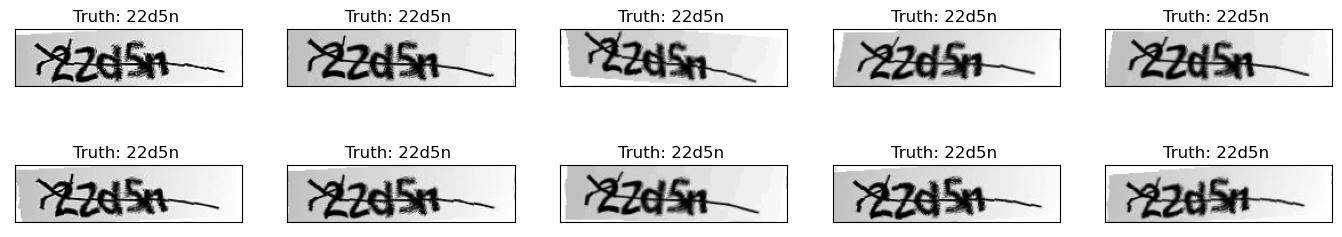

In [5]:
fig = plt.figure(figsize=(17, 5))
for i in range(10):
    img, label = train[1]
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    title = f"Truth: {label} "

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

# Architecture

**Архитектура сети пострроена по аналогии со [статьей](https://arxiv.org/pdf/1507.05717v1.pdf)**

In [6]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, dropout=0.5):
        super(CRNN, self).__init__()

        self.FCNN = nn.Sequential(
            # nn.Dropout(dropout),
            nn.Conv2d(1, 32, (3, 3), stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 2), 2),
            nn.Conv2d(32, 64, (3, 3), stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 2), 2),
            nn.Conv2d(64, 128, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d((1, 2), 2),
            nn.Conv2d(256, 512, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d((1, 2), 2),
            nn.Conv2d(512, 512, (2, 2), stride=1, padding=0),
            nn.Dropout(dropout),
        )

        self.conv_to_seq = nn.Sequential(nn.Linear(1024, 256), nn.Dropout(dropout))

        self.lstm = nn.LSTM(
            256, 256, bidirectional=True, num_layers=2, batch_first=True
        )

        self.out = nn.Sequential(
            nn.Linear(512, vocab_size),
        )

    def forward(self, x, device="cpu"):

        x = self.FCNN(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)

        x = self.conv_to_seq(x)
        x, _ = self.lstm(x)

        x = self.out(x)
        return x.permute(1, 0, 2)

# Controller class

Класс контроллер для обучения и инференса

В обучении реализованы фичи клиппинга градиентов, сохранения наилучшей модели и уменьшения шага при выходе на плато

In [7]:
class CaptchaReader:
    def __init__(self, chars="abcdefghijklmnopqrstuvwxyz0123456789"):

        self.device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )
        self.chars = chars
        vocab_size = len(chars) + 1
        self.crnn = CRNN(vocab_size).to(self.device)
        print("Model loaded to ", self.device)

        self.critertion = nn.CTCLoss(blank=0)

        self.char2idx, self.idx2char = self.char_idx()

    def char_idx(self):
        char2idx = {}
        idx2char = {}

        characters = self.chars.lower() + "-"
        for i, char in enumerate(characters):
            char2idx[char] = i + 1
            idx2char[i + 1] = char

        return char2idx, idx2char

    def encode_labels(self, labels):
        length_per_label = [len(label) for label in labels]
        joined_label = "".join(labels)

        joined_encoding = []
        for char in joined_label:
            joined_encoding.append(self.char2idx[char])

        return (torch.IntTensor(joined_encoding), torch.IntTensor(length_per_label))

    def decode_logits(self, logits):
        tokens = logits.softmax(2).argmax(2).squeeze(1)

        tokens = "".join(
            [self.idx2char[token] if token != 0 else "-" for token in tokens.numpy()]
        )
        tokens = tokens.split("-")

        text = [
            char
            for batch_token in tokens
            for idx, char in enumerate(batch_token)
            if char != batch_token[idx - 1] or len(batch_token) == 1
        ]
        text = "".join(text)

        return text

    def get_loss(self, logits, labels):
        encoded_labels, labels_len = self.encode_labels(labels)

        logits_lens = torch.full(
            size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.int32
        ).to(self.device)

        return self.critertion(
            logits.log_softmax(2), encoded_labels, logits_lens, labels_len
        )

    def train_step(self, optimizer, images, labels):
        logits = self.predict(images)

        optimizer.zero_grad()
        loss = self.get_loss(logits, labels)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.crnn.parameters(), 1, norm_type="inf")
        optimizer.step()

        return logits, loss

    def predict(self, img):
        return self.crnn(img.to(self.device), self.device)

    def train(
        self,
        num_epochs,
        optimizer,
        train_loader,
        val_loader,
        lr_scheduler,
        print_every=2,
        save_name = "best-model-parameters.pt"
    ):
        train_losses, valid_losses, val_cers = [], [], []

        best_cer = 1.0
        for epoch in range(num_epochs):
            start = time.time()
            tot_train_loss = 0
            self.crnn.train()
            for i, (images, labels) in enumerate(train_loader):

                logits, train_loss = self.train_step(optimizer, images, labels)
                tot_train_loss += train_loss.item()

            with torch.no_grad():

                tot_val_loss = 0
                self.crnn.eval()

                true_labels = []
                pred_labels = []
                for i, (images, labels) in enumerate(val_loader):
                    logits = self.predict(images)
                    val_loss = self.get_loss(logits, labels)

                    logits = logits.cpu()
                    for j in range(logits.size(1)):
                        pred_labels.append(
                            self.decode_logits(logits[:, j, :].unsqueeze(1))
                        )

                    true_labels += list(labels)
                    tot_val_loss += val_loss.item()

                # print(pred_labels, true_labels)
                val_cer = CER()(pred_labels, true_labels)
                train_loss = tot_train_loss / len(train_loader.dataset)
                val_loss = tot_val_loss / len(val_loader.dataset)
                lr_scheduler.step(val_cer)

                train_losses.append(train_loss)
                valid_losses.append(val_loss)
                val_cers.append(val_cer)

                if val_cer < best_cer:
                    best_cer = val_cer
                    torch.save(self.crnn.state_dict(), save_name)

            elapsed_time = time.time() - start
            if epoch % print_every == 0:
                lr = optimizer.param_groups[0]["lr"]
                print(
                    "Epoch {:3d}/{:3d}   train_loss: {:6.4f}   val_loss: {:6.4f}   val_cer: {:6.4f}   best_cer: {:6.4f}   epoch_time: {:6.4f}s   lr: {:8f}".format(
                        epoch + 1,
                        num_epochs,
                        train_loss,
                        val_loss,
                        val_cer,
                        best_cer,
                        elapsed_time,
                        lr,
                    )
                )

        return train_losses, valid_losses

# Training

In [45]:
IMAGES_PATH = "laba-dataset/samples/samples/"
BATCH_SIZE = 8
N_WORKERS = 4
EPOCHS = 80
LR = 0.00015
LR_SCHEDULER_PATIENCE = 4
LR_SCHEDULER_FACTOR = 0.7
LR_SCHEDULER_COOLDOWN = 2

In [46]:
train, val, test = train_val_test_split_datasets(IMAGES_PATH, ratios=(0.75, 0.25, 0.0))
train_loader = DataLoader(
    train, batch_size=BATCH_SIZE, num_workers=N_WORKERS, shuffle=True
)
val_loader = DataLoader(
    val, batch_size=BATCH_SIZE, num_workers=N_WORKERS, shuffle=False
)

captcha_reader = CaptchaReader()
optimizer = optim.Adam(captcha_reader.crnn.parameters(), lr=LR)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    "min",
    patience=LR_SCHEDULER_PATIENCE,
    cooldown=LR_SCHEDULER_COOLDOWN,
    factor=LR_SCHEDULER_FACTOR,
)

Model loaded to  cuda


In [47]:
train_losses, val_losses = captcha_reader.train(
    EPOCHS, optimizer, train_loader, val_loader, lr_scheduler, print_every=1
)

Epoch   1/ 80   train_loss: 0.4507   val_loss: 0.4197   val_cer: 1.0000   best_cer: 1.0000   epoch_time: 11.7954s   lr: 0.000150
Epoch   2/ 80   train_loss: 0.4048   val_loss: 0.4228   val_cer: 1.0000   best_cer: 1.0000   epoch_time: 12.0432s   lr: 0.000150
Epoch   3/ 80   train_loss: 0.4035   val_loss: 0.4305   val_cer: 1.0000   best_cer: 1.0000   epoch_time: 11.9478s   lr: 0.000150
Epoch   4/ 80   train_loss: 0.4030   val_loss: 0.4251   val_cer: 1.0000   best_cer: 1.0000   epoch_time: 12.3424s   lr: 0.000150
Epoch   5/ 80   train_loss: 0.3987   val_loss: 0.4115   val_cer: 1.0000   best_cer: 1.0000   epoch_time: 12.2301s   lr: 0.000150
Epoch   6/ 80   train_loss: 0.3780   val_loss: 0.3884   val_cer: 1.0000   best_cer: 1.0000   epoch_time: 12.3035s   lr: 0.000105
Epoch   7/ 80   train_loss: 0.3499   val_loss: 0.3530   val_cer: 0.9008   best_cer: 0.9008   epoch_time: 12.6909s   lr: 0.000105
Epoch   8/ 80   train_loss: 0.3037   val_loss: 0.3006   val_cer: 0.8654   best_cer: 0.8654   epoc

## Losses during training plot

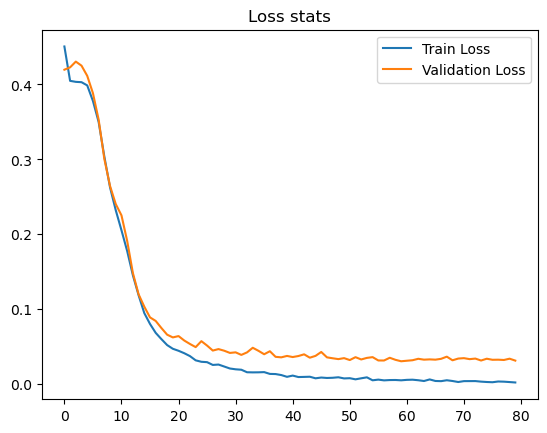

In [48]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss stats")
plt.legend()
plt.show()

# Result analysis

In [49]:
captcha_reader.crnn.load_state_dict(torch.load("best-model-parameters-2.77cer.pt"))

<All keys matched successfully>

In [50]:
def get_cer(model, dataset):
    pred_labels, true_labels = [],[]
    model.crnn.eval()
    for img, label in dataset:
        logits = model.predict(img.unsqueeze(0))
        pred_text = model.decode_logits(logits.cpu())
        
        pred_labels.append(pred_text)
        true_labels.append(label)
    return CER()(pred_labels,true_labels)

In [51]:
val_cer = get_cer(captcha_reader, val).item()
print(f"CER on validation dataset : {round(val_cer*100,2)}%")

CER on validation dataset : 2.77%


## Visualize 20 random predictions

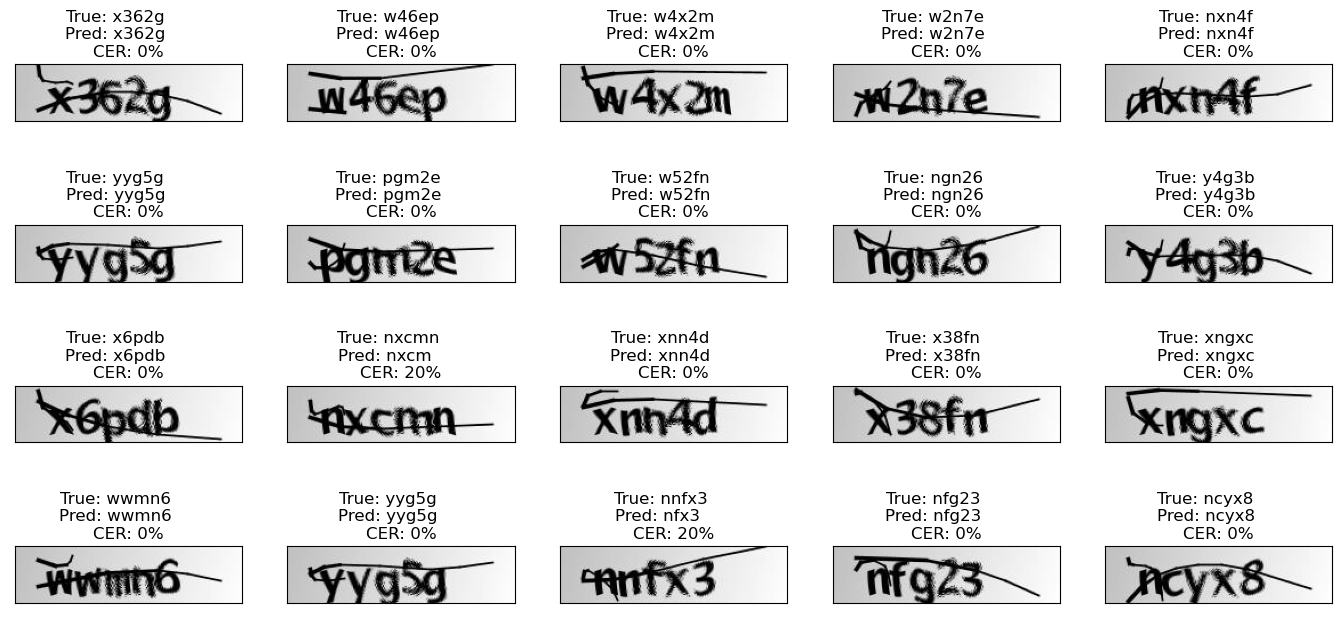

In [52]:
sample_result = []
samples = 20
for i in range(20):
    idx = np.random.randint(len(val))
    img, label = val[idx]
    logits = captcha_reader.predict(img.unsqueeze(0))
    pred_text = captcha_reader.decode_logits(logits.cpu())
    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 8))
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    cer = CER()([pred_text], [label]).item() * 100
    title = f"True: {label:10}\nPred: {pred_text:10}\nCER: {round(cer)}%"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

## Errors analysis

In [53]:
pred_labels = []
true_labels = []
cers = []
for idxm, (img, label) in enumerate(val):
    logits = captcha_reader.predict(img.unsqueeze(0))
    pred_label = captcha_reader.decode_logits(logits.cpu())
    cer = CER()(pred_label, label).item()

    true_labels.append(label)
    pred_labels.append(pred_label)
    cers.append(cer)

In [54]:
top_errors = sorted(
    list(zip(range(len(val)), cers, true_labels, pred_labels)),
    key=lambda x: x[1],
    reverse=True,
)
K = 20
top_k_errors = top_errors[:K]
top_k_errors

[(211, 0.6000000238418579, 'xyyyw', '2yw'),
 (17, 0.4000000059604645, 'neggn', 'nen'),
 (41, 0.4000000059604645, 'nnn57', 'n57'),
 (42, 0.4000000059604645, 'nnn5p', 'n5p'),
 (8, 0.20000000298023224, 'ncww7', 'ncw7'),
 (20, 0.20000000298023224, 'nf8b8', 'nfb8'),
 (33, 0.20000000298023224, 'nm46n', 'nmd46n'),
 (36, 0.20000000298023224, 'nn4wx', 'n4wx'),
 (39, 0.20000000298023224, 'nnfx3', 'nfx3'),
 (51, 0.20000000298023224, 'nxcmn', 'nxcm'),
 (63, 0.20000000298023224, 'p2x7x', 'p27x'),
 (75, 0.20000000298023224, 'pbpgc', 'bpgc'),
 (76, 0.20000000298023224, 'pcede', 'pcde'),
 (88, 0.20000000298023224, 'pgg3n', 'pg3n'),
 (119, 0.20000000298023224, 'w2yp7', 'gw2yp7'),
 (130, 0.20000000298023224, 'w7e6m', 'mw7e6m'),
 (136, 0.20000000298023224, 'wce5n', 'gce5n'),
 (139, 0.20000000298023224, 'wdww8', 'wdw8'),
 (144, 0.20000000298023224, 'wgnwp', 'wgmwp'),
 (146, 0.20000000298023224, 'wm746', 'wm74')]

### Visualization of top-20 CER errors

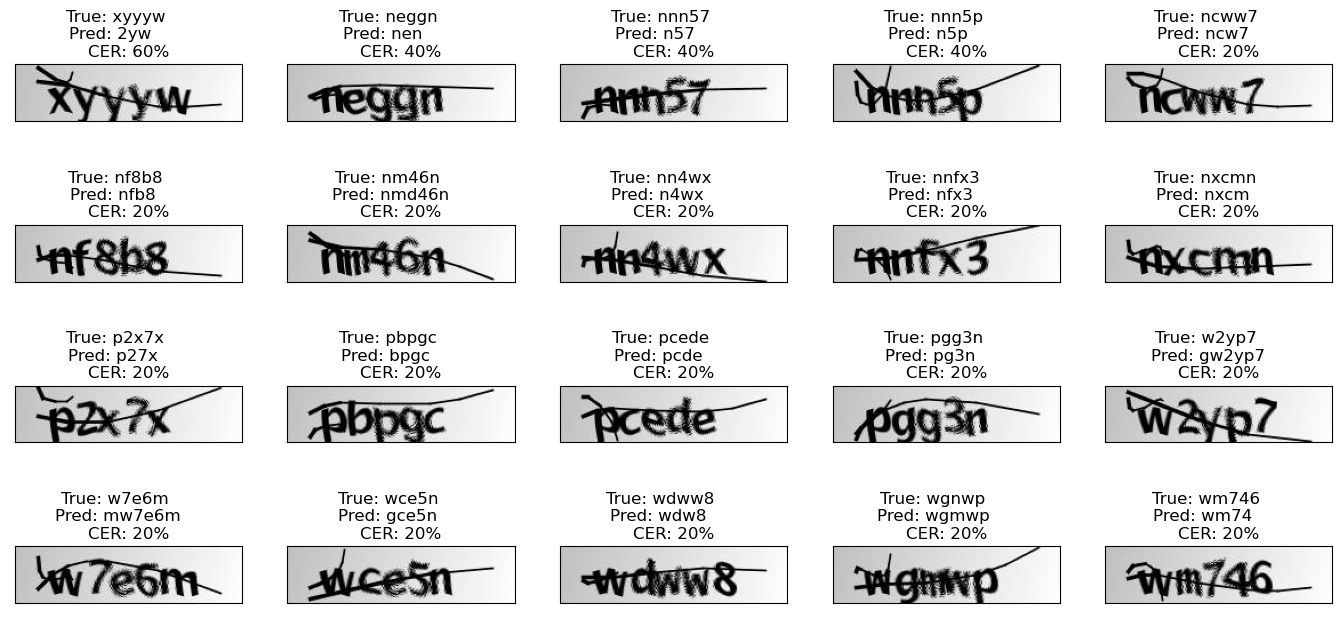

In [55]:
fig = plt.figure(figsize=(17, 8))
for i in range(K):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    idx, cer, label, pred_text = top_k_errors[i]
    img = val[idx][0]
    title = f"True: {label:10}\nPred: {pred_text:10}\nCER: {round(cer*100)}%"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

### Explanations

Если откинуть ошибки, которые получились за счет неудачных стечений обстоятельств (неверная разметка, случаи когда линии на фоне довольно сильно накладываются на буквы, или очень похожие сливающиеся m и n), то можно выделить 2 типа ошибочных случаев:

* Когда в слове один и тот же символ встречается несколько раз. Довольно частая ошибка. Может быть вызвана тем, что в тренировочных данных многие символы присутстувют только один раз. Вообще выглядит так, что на определенном уровне модель пытается просто детектить факт присутствия буквы в слове.
* Когда почему-то не распознаются довольно понятные для человека символы. Я связываю это с тем, что содержащиеся в модели LSTM-ки могут обучится тому, что какой-то определенный символ в тренеровочной выборке почти не встречается в определенной части слова, соответсвенно модель обучилась его там не ожидать.

Решением обоих проблем может стать генерация тренировочных данных "на ходу" с возможностью получать капчу со случайным текстом. Таким образом текст на капче станет более разнообразным предотвратятся случаи с того, что модель переобучается под нахождение опредленной буквы в определенной части слова. Кроме того это еще должно пофиксить и проблемы с повторяющимися буквами.

Также решением проблем может стать понижение размерностей скрытых слоев моделей, уменьшение глубины или большая регуляризация модели. В общем все то, что могло бы уменьшить ее склонность к переобучению. Но решение в абзаце выше мне кажется идеологически более правильным, так как тренировочных данных действительно не очень много.

Третье решение проблем может быть получено за счет кардинального изменения архитектуры. Например можно насильно заставить модель выдавать ровно 5 символов на выходе (сделать это можно многими разными способами. Можно убрать рекуррентный слой. Можно сделать что-то типа семантической сегементации букв на капче каким-нибудь U-net-ом и потом распознавание каждого символа по отдельности. Фантазировать можно долго :)